In [1]:
import numpy as np
import runstats
import gym
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from BAC import TabularBAC
from BAC import TabularEPBAC

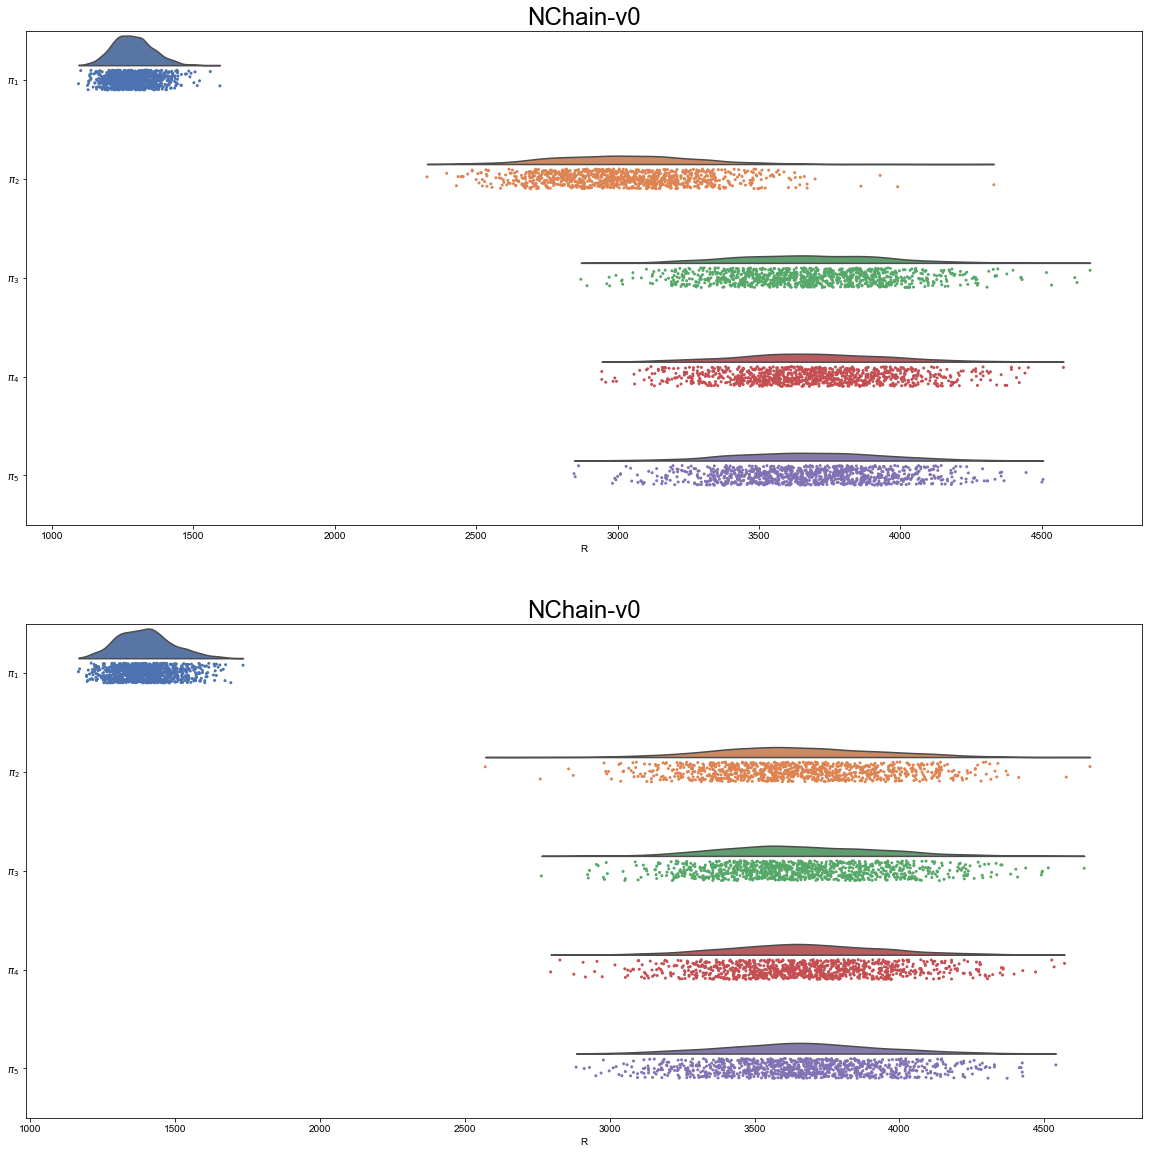

In [2]:
gamma = 0.99
alpha = 0.1
beta = -1
num_samples = 100
num_iterations = 1000
max_episodes = 5
eval_episodes = 1000
num_updates = 5

def eval_env(env_name, eval_episodes, agent):
    _env = gym.make(env_name)
    _env.max_episode_steps=200
    _s = _env.reset()
    _episodic_reward = 0
    _returns = np.zeros((eval_episodes))
    for i in range(eval_episodes):
        while True:
            a = agent.get_action(_s)
            _s_, _r, _done, _ = _env.step(a)
            _episodic_reward += _r
            if _done:
                _s = _env.reset()
                _returns[i] = _episodic_reward
                _episodic_reward = 0
                break
            else:
                _s = _s_
    return _returns
                

returns = np.zeros((2, eval_episodes, num_updates))

env = gym.make("NChain-v0")
env.max_episode_steps=200
num_states = env.observation_space.n
num_actions = env.action_space.n
BAC = TabularBAC(num_states, num_actions, gamma, alpha, num_samples, num_iterations)
s = env.reset()
for t in range(max_episodes):
    BAC.update_policy()   
    returns[0, :, t] = eval_env("NChain-v0", eval_episodes, BAC) # Now evaluate policy
    while True:
        a = BAC.get_action(s)
        s_, r, done, _ = env.step(a)
        BAC.update(s, a, r, s_, done)
        if done:
            s = env.reset()
            break
        else:
            s = s_

EPBAC = TabularEPBAC(num_states, num_actions, gamma, alpha, beta, num_samples, num_iterations)
s = env.reset()
for t in range(max_episodes):
    EPBAC.update_policy()   
    returns[1, :, t] = eval_env("NChain-v0", eval_episodes, EPBAC) # Now evaluate policy
    while True:
        a = EPBAC.get_action(s)
        s_, r, done, _ = env.step(a)
        EPBAC.update(s, a, r, s_, done)
        if done:
            s = env.reset()
            break
        else:
            s = s_
            
f, ax = plt.subplots(2, 1, figsize=(20,20))
for i in range(2):
    df = pd.DataFrame(returns[i,:, :], columns=[r'$\pi_1$', r'$\pi_2$', r'$\pi_3$', r'$\pi_4$', r'$\pi_5$'])
    sns.set(style="whitegrid", font_scale=2)
    ort = "h";
    pal = sns.color_palette(n_colors=5)
    ax[i] = pt.half_violinplot(data=df, palette=pal, bw=.2, cut=0.,
                            scale="area", width=.6, inner=None, orient=ort, ax=ax[i])
    ax[i] = sns.stripplot(data=df, palette=pal, edgecolor="white",
                       size=3, jitter=1, zorder=0, orient=ort, ax=ax[i])
    ax[i].set_xlabel("R")
    ax[i].set_title("NChain-v0")
plt.show()